In [1]:
%load_ext nb_black

from itertools import product
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from joblib import Parallel, delayed
from graspy.plot import heatmap
from scipy.stats import ttest_ind

from src import generate_binary_sbms, compute_pr_at_k

%matplotlib inline

/Users/j1c/miniconda3/envs/graspy/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


ImportError: cannot import name 'generate_binary_sbms' from 'src' (/Users/j1c/git/twins/src/__init__.py)

<IPython.core.display.Javascript object>

In [3]:
from datetime import datetime

today = datetime.today().strftime("%Y%m%d")
print(today)

20200207


<IPython.core.display.Javascript object>

In [3]:
def compute_ttest(pop1, pop2):
    statistics, pvals = ttest_ind(pop1, pop2, axis=0)
    # np.nan_to_num(statistics, copy=False)

    return statistics, pvals

def run_experiment(m, block_1, block_2, p, delta, k, reps):
    precisions = []
    recalls = []
    for i in np.arange(reps):
        tmp_precisions = []
        tmp_recalls = []
        X, Y, true_labels = generate_binary_sbms(
            m=m, block_1=block_1, block_2=block_2, p=p, delta=delta
        )
        test_statistics, pvals = compute_ttest(X, Y)

        precision, recall = compute_pr_at_k(pvals, k, true_labels)
        precisions.append(precision)
        recalls.append(recall)

    precisions = np.array(precisions).mean(axis=0)
    recalls = np.array(recalls).mean(axis=0)

    to_append = [p, delta, m, *precisions, *recalls]

    return to_append

<IPython.core.display.Javascript object>

In [10]:
# Experiment Parameters
# Constants
block_1 = 5
block_2 = 15
p = 0.5
reps = 100
ks = range(5, 11)

# Varying
spacing = 100
deltas = np.linspace(0, 1 - p, spacing + 1)
ms = np.linspace(10, 500, spacing + 1)[1:]  # Dont want 0 samples

<IPython.core.display.Javascript object>

In [6]:
partial_func = partial(
    run_experiment, block_1=block_1, block_2=block_2, p=p, k=ks, reps=reps
)

args = [dict(m=m, delta=delta) for m, delta in product(ms, deltas)]

res = Parallel(n_jobs=-2, verbose=1)(delayed(partial_func)(**arg) for arg in args)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 95 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-2)]: Done 260 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-2)]: Done 610 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-2)]: Done 1060 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-2)]: Done 1610 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done 2260 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-2)]: Done 3010 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-2)]: Done 3860 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-2)]: Done 4810 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-2)]: Done 5860 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-2)]: Done 7010 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-2)]: Done 9610 tasks      | elapsed: 52.6min
[Parallel(n_jobs=-2)]: Done 10100 out of 10100 | elapsed: 57.6min finished


<IPython.core.display.Javascript object>

In [8]:
cols = [
    "p",
    "delta",
    "m",
    *[f"precision_at_{k}" for k in ks],
    *[f"recall_at_{k}" for k in ks],
]
res_df = pd.DataFrame(res, columns=cols)

res_df.to_csv(f"{today}_results.csv", index=False)

<IPython.core.display.Javascript object>

# Figures

In [2]:
res_df = pd.read_csv("20200206_results.csv")

res_df.head()

,p,delta,m,precision_at_5,precision_at_6,precision_at_7,precision_at_8,precision_at_9,precision_at_10,recall_at_5,recall_at_6,recall_at_7,recall_at_8,recall_at_9,recall_at_10
0,0.5,0.000,14.9,0.078,0.076667,0.068571,0.06750,0.064444,0.061,0.039,0.046,0.048,0.054,0.058,0.061
1,0.5,0.005,14.9,0.042,0.046667,0.054286,0.05625,0.057778,0.058,0.021,0.028,0.038,0.045,0.052,0.058
2,0.5,0.010,14.9,0.054,0.053333,0.051429,0.05375,0.055556,0.056,0.027,0.032,0.036,0.043,0.050,0.056
3,0.5,0.015,14.9,0.070,0.065000,0.065714,0.06375,0.063333,0.062,0.035,0.039,0.046,0.051,0.057,0.062
4,0.5,0.020,14.9,0.072,0.068333,0.071429,0.06750,0.068889,0.068,0.036,0.041,0.050,0.054,0.062,0.068


<IPython.core.display.Javascript object>

In [3]:
# Remove delta == 0
res_df = res_df[res_df.delta != 0]

<IPython.core.display.Javascript object>

In [ ]:
fmt = lambda x: "{:.2f}".format(x)

p = 0.5
spacing = 100
deltas = np.linspace(0, 1 - p, spacing + 1)[::20]
deltas[0] += 0.005
ms = np.linspace(0, 500, spacing + 1)[::20] * 2
ms[0] += 20

with sns.plotting_context("talk", font_scale=1.1):
    fig, ax = plt.subplots(
        1,
        2,
        gridspec_kw={"width_ratios": [1, 0.05]},
        figsize=(7.2, 6),
        constrained_layout=True,
    )

    sns.heatmap(
        np.flipud(res_df[f"precision_at_10"].values.reshape(spacing, -1)),
        ax=ax[0],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=[fmt(d) for d in deltas],
        yticklabels=["{:.0f}".format(m) for m in ms],
        cbar_ax=ax[-1],
        vmin=0,
        vmax=1,
    )
    ax[0].set_xticks(np.arange(0, ax[0].get_xlim()[1] + 1, 20))
    ax[0].set_yticks(np.arange(0, ax[0].get_ylim()[0] + 1, 20)[::-1])
    ax[0].set_ylabel("Sample Size")
    ax[0].set_xlabel("Effect Size", labelpad=15)

    fig.text(1.05, 0.6, "Precision@10", va="center", ha="center", rotation="vertical")

    fig.savefig("./figures/20200206_power.png", dpi=300, bbox_inches="tight")
    fig.savefig("./figures/20200206_power.pdf", bbox_inches="tight")

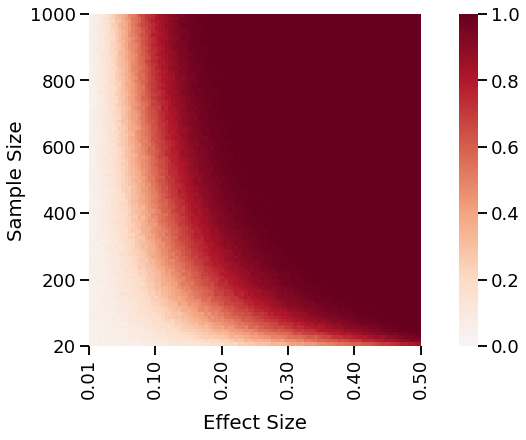

<IPython.core.display.Javascript object>

In [4]:
fmt = lambda x: "{:.2f}".format(x)

p = 0.5
spacing = 100
deltas = np.linspace(0, 1 - p, spacing + 1)[::20]
deltas[0] += 0.005
ms = np.linspace(0, 500, spacing + 1)[::20] * 2
ms[0] += 20

with sns.plotting_context("talk", font_scale=1.1):
    fig, ax = plt.subplots(
        1,
        2,
        gridspec_kw={"width_ratios": [1, 0.05]},
        figsize=(7.2, 6),
        constrained_layout=True,
    )

    sns.heatmap(
        np.flipud(res_df[f"precision_at_10"].values.reshape(spacing, -1)),
        ax=ax[0],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=[fmt(d) for d in deltas],
        yticklabels=["{:.0f}".format(m) for m in ms],
        cbar_ax=ax[-1],
        vmin=0,
        vmax=1,
    )
    ax[0].set_xticks(np.arange(0, ax[0].get_xlim()[1] + 1, 20))
    ax[0].set_yticks(np.arange(0, ax[0].get_ylim()[0] + 1, 20)[::-1])
    ax[0].set_ylabel("Sample Size")
    ax[0].set_xlabel("Effect Size", labelpad=15)

    # fig.text(1.05, 0.6, "Precision@10", va="center", ha="center", rotation="vertical")

    fig.savefig(
        "./figures/20200206_power_no_cbar_label.png", dpi=300, bbox_inches="tight"
    )
    fig.savefig("./figures/20200206_power_no_cbar_label.pdf", bbox_inches="tight")